# Clustering the Beaded Helix With Non-Uniform Frame Weights

## Import Libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch

## Read trajectory

In [5]:
prmtopFileName = "helix_template.pdb"
trajFileName = "helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Perform Cross Validation with Uniform Weights

Here we will perform a cluster scan assuming each frame has the same weight.  This is exactly what we did in the other notebook.

In [8]:
# define cluster array
cluster_array = np.arange(1,7,1).astype(int)

In [6]:
# uniform weights
train, cv = scripts.cross_validate_cluster_scan(traj_data, 2000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 2000
Number of frames to predict each model: 8001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              36.179          21.594
              1               1               2              36.179          21.319
              1               1               3              36.179          21.301
              1               1               4              36.179          21.268
              1               1               5              36.179          21.295
              1               2               1              40.524           6.654
              1               2               2              40.376           4.197
              1               2               3              40.552 

## Perform Cross Validation with ENM Weights for each Frame

I have calculated the weight of each frame of this trajectory assuming it came from an ENM model.  This should bias towards only finding the right- and left-handed helices and ignoring anything else.  

In [7]:
# load the weights
frame_weights = np.loadtxt("enm_weights.dat")
print(np.sum(frame_weights))

1.0


In [12]:
# CV scan with non-uniform weights
enm_train, enm_cv = scripts.cross_validate_cluster_scan(traj_data, 2000, frame_weights = frame_weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 2000
Number of frames to predict each model: 8001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              42.901          15.894
              1               1               2              42.901          15.874
              1               1               3              42.901          16.067
              1               1               4              42.901          15.745
              1               1               5              42.901          15.829
              1               2               1              43.992          16.506
              1               2               2              43.963           9.228
              1               2               3              48.007 

## Perform Cross-Validation with Random Weights for each Frame

In [10]:
# load the weights
random_frame_weights = np.random.rand(frame_weights.shape[0])
random_frame_weights /= np.sum(random_frame_weights)

In [13]:
# CV scan with non-uniform weights
random_train, random_cv = scripts.cross_validate_cluster_scan(traj_data, 2000, frame_weights = random_frame_weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 2000
Number of frames to predict each model: 8001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              36.152          21.075
              1               1               2              36.152          21.027
              1               1               3              36.152          21.096
              1               1               4              36.152          20.863
              1               1               5              36.152          20.942
              1               2               1              38.974          27.452
              1               2               2              39.379          29.620
              1               2               3              39.968 

## Make Log Likelihood vs number of Cluster Plots

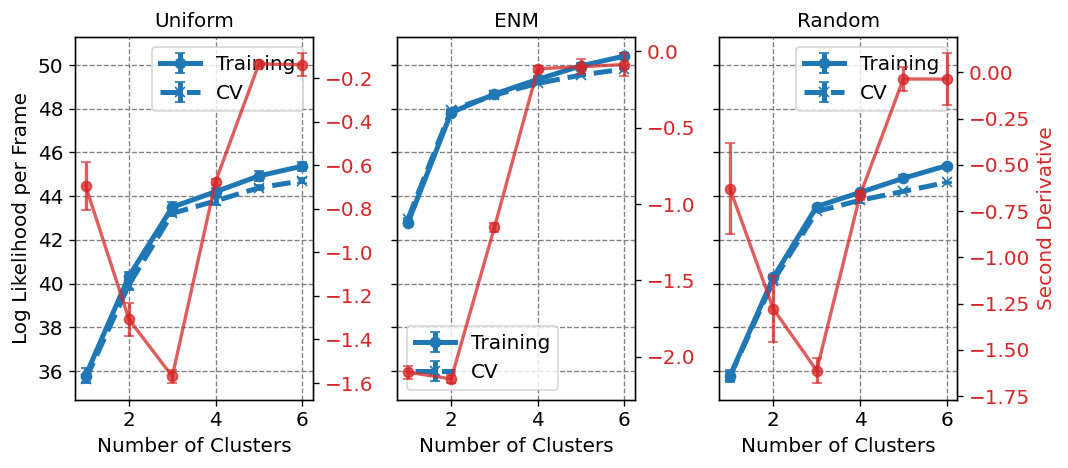

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_log_likelihood_with_dd(axis,cluster_array,train_log_lik,valid_log_lik,fontsize=16,xlabel=True,ylabel1=True,ylabel2=True):
    colors = ["tab:blue", "tab:red"]
    # Training Data
    train_mean = np.mean(train_log_lik,axis=1)
    train_std = np.std(train_log_lik,axis=1)
    axis.errorbar(cluster_array,train_mean,train_std,fmt='-o',lw=3,capsize=3,c=colors[0],label="Training")
    # Validation
    valid_mean = np.mean(valid_log_lik,axis=1)
    valid_std = np.std(valid_log_lik,axis=1)
    axis.errorbar(cluster_array,valid_mean,valid_std,fmt='--x',lw=3,capsize=3,c=colors[0],label="CV")
    # Second derivative
    ax2 = axis.twinx()
    n_samples = train_log_lik.shape[1]
    n_clusters = train_log_lik.shape[0]
    dd = np.empty(train_log_lik.shape)
    for sample in range(n_samples):
        dd[:,sample] = np.gradient(np.gradient(train_log_lik[:,sample]))
    dd_mean = np.mean(dd,axis=1)
    dd_std = np.std(dd,axis=1)
    ax2.errorbar(cluster_array,dd_mean,dd_std,fmt='-o',lw=2,capsize=3,alpha=0.75,c=colors[1])
    #
    axis.grid(which='major', axis='both', color='#808080', linestyle='--')
    if ylabel1==True:
        axis.set_ylabel("Log Likelihood per Frame",fontsize=fontsize)
    if ylabel2==True:
        ax2.set_ylabel("Second Derivative",fontsize=fontsize,color=colors[1])
    if xlabel==True:
        axis.set_xlabel("Number of Clusters",fontsize=fontsize)
    ax2.tick_params(axis='both',labelsize=fontsize,labelcolor=colors[1])
    axis.tick_params(axis='both',labelsize=fontsize)
    axis.legend(fontsize=fontsize)
    
# create figure
fig, ax = plt.subplots(1,3,figsize=(9,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
# Uniform Weights
ax[0].set_title("Uniform",fontsize=12)
plot_log_likelihood_with_dd(ax[0],cluster_array,train,cv,fontsize=12,ylabel1=True,ylabel2=False,xlabel=True)
# ENM Weights
ax[1].set_title("ENM",fontsize=12)
plot_log_likelihood_with_dd(ax[1],cluster_array,enm_train,enm_cv,fontsize=12,ylabel1=False,ylabel2=False,xlabel=True)
# Random Weights
ax[2].set_title("Random",fontsize=12)
plot_log_likelihood_with_dd(ax[2],cluster_array,random_train,random_cv,fontsize=12,ylabel1=False,ylabel2=True,xlabel=True)
# show plot
plt.tight_layout()
plt.show()